Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



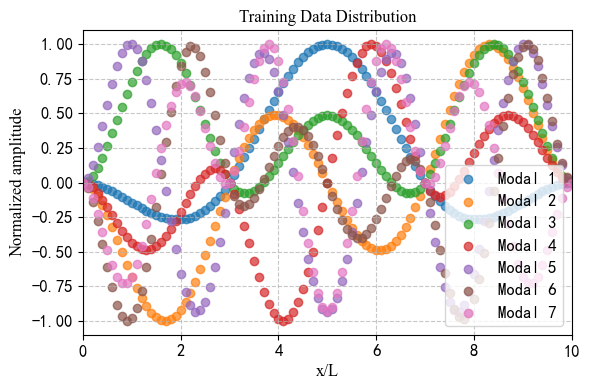

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           128         ['input_1[0][0]']                
                                                                                                  
 tf_op_layer_strided_slice_1 (T  [(None, 1)]         0           ['input_1[0][0]']                
 ensorFlowOpLayer)                                                                                
                                                                                                  
 dense_1 (Dense)                (None, 64)           4160        ['dense[0][0]']              

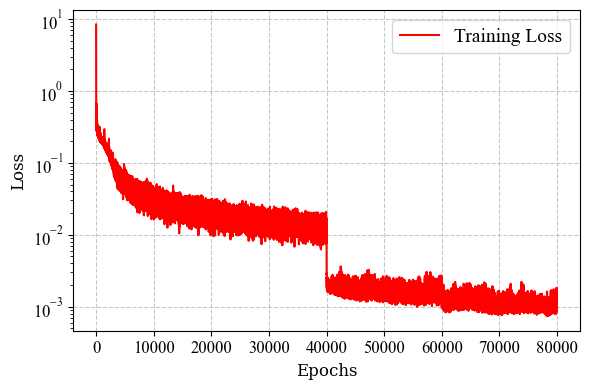

C:\Users\PS\anaconda3\envs\deepxde\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


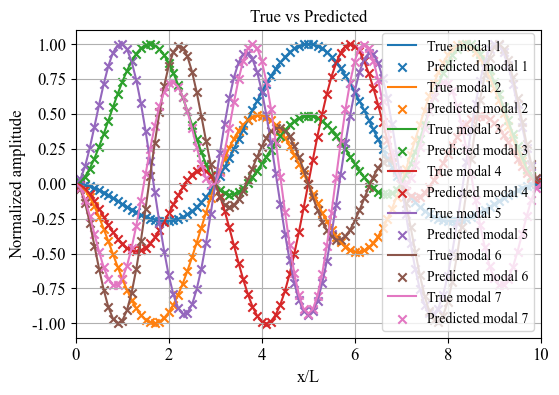

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sympy import integrate, exp, sin, log, oo, pi,symbols
import deepxde as dde
import scipy.io as scio
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf
import datetime
import os
from pylab import mpl
from scipy.signal import chirp, spectrogram
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
from matplotlib.pyplot import MultipleLocator
import re
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from math import sqrt, pi

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LambdaCallback


def sin_activation(x):
    return tf.math.sin(x)
get_custom_objects().update({'sin': Activation(sin_activation)})

data_pre = np.loadtxt('Mode shape.txt')  
X_pre =np.arange(0, 10.1, 0.1).reshape(-1, 1) 

y_pre = data_pre[:, 0:7]              

y_pre = y_pre / np.max(y_pre, axis=0)

font = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}


plt.figure(figsize=(6,4))
for i in range(y_pre.shape[1]):
    plt.scatter(X_pre, y_pre[:, i], label=f'Modal {i+1}', alpha=0.7)

plt.title("Training Data Distribution",fontdict=font)
plt.xlabel("x/L",fontdict=font)
plt.ylabel("Normalized amplitude",fontdict=font)
plt.xlim([0,10])
plt.legend(loc='lower right', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  
plt.savefig('modal_train data.png', dpi=300)  
plt.show()

w_nodenum_pre =64 
w_layer_pre = 4   
activation_func_pre = "relu"  

def modify_output_pre(X):
    ww = tf.keras.layers.Dense(w_nodenum_pre, activation=activation_func_pre)(X)
    for i in range(w_layer_pre):  
        ww = tf.keras.layers.Dense(w_nodenum_pre, activation=activation_func_pre)(ww)
    ww = X[:, 0:1]* (X[:, 0:1] - 10)* (X[:, 0:1] - 3) * (X[:, 0:1] - 7)* tf.keras.layers.Dense(7, activation=None)(ww)
    return ww

inputs_pre = tf.keras.Input(shape=(1,))
output_pre = modify_output_pre(inputs_pre)


pre_model = tf.keras.Model(inputs=inputs_pre, outputs=output_pre)

pre_model.summary()



def scheduler(epoch, lr):
    if epoch < 40000:
        return 0.001  
    elif epoch >= 40000 and epoch < 60000:
        return 0.0001  
    else:
        return 0.00005  

lr_scheduler = LearningRateScheduler(scheduler)

tf.compat.v1.disable_eager_execution()

history1 = pre_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mae',  # 使用 Mean Absolute Error
    metrics=['accuracy']
)

def on_epoch_end(epoch, logs):
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1}, Loss: {logs['loss']:.4f}")

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
history1 = pre_model.fit(
    X_pre, y_pre,
    epochs= 80000,  
    batch_size=128,  
    callbacks=[print_callback, lr_scheduler],  
    verbose=0  
)

for layer in pre_model.layers:
    layer.trainable = False

plt.figure(figsize=(6, 4))
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(history1.history['loss'], label='Training Loss', color='red', linestyle='-')
plt.yscale('log')
plt.title('', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.xlabel('Epochs', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.ylabel('Loss', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('modal_train.png', dpi=300)
plt.show()
    
y_train_pred = pre_model.predict(X_pre)

plt.figure(figsize=(6,4))
plt.rcParams['font.family'] = 'Times New Roman'
for i in range(y_pre.shape[1]):
    plt.plot(X_pre, y_pre[:, i], label=f'True modal {i+1}', alpha=1)  
    plt.scatter(X_pre, y_train_pred[:, i], label=f'Predicted modal {i+1}', alpha=1, marker='x')  
plt.title("True vs Predicted", fontdict=font)
plt.xlabel("x/L", fontdict=font)
plt.ylabel("Normalized amplitude", fontdict=font)
plt.xlim(0, 10)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12) 
plt.legend(loc='lower right', fontsize=10)  
plt.grid(True)
plt.savefig('modal_pre.png', dpi=300)  
plt.show()

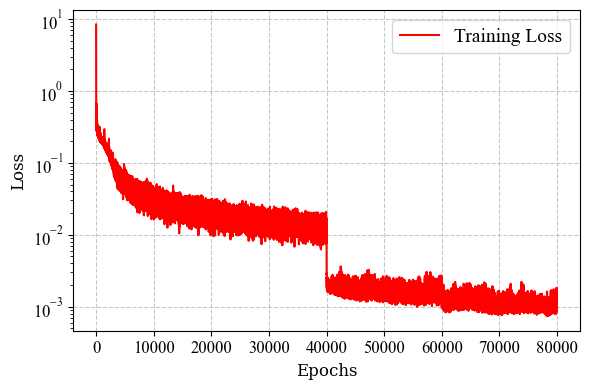

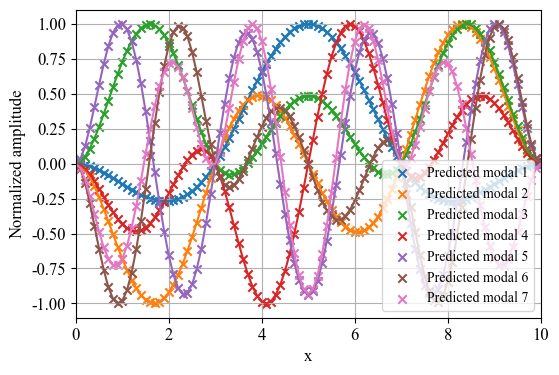

In [2]:
plt.figure(figsize=(6, 4))
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(history1.history['loss'], label='Training Loss', color='red', linestyle='-')

plt.yscale('log')
plt.title('', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.xlabel('Epochs', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.ylabel('Loss', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('modal_train.png', dpi=300)
plt.show()
    

y_train_pred = pre_model.predict(X_pre)

plt.figure(figsize=(6,4))
plt.rcParams['font.family'] = 'Times New Roman'
for i in range(y_pre.shape[1]):
    plt.plot(X_pre, y_pre[:, i], label='', alpha=1)  
    plt.scatter(X_pre, y_train_pred[:, i], label=f'Predicted modal {i+1}', alpha=1, marker='x') 
plt.title("", fontdict=font)
plt.xlabel("x", fontdict=font)
plt.ylabel("Normalized amplitude", fontdict=font)
plt.xlim(0, 10)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.legend(loc='lower right', fontsize=10)  
plt.grid(True)
plt.savefig('modal_pre.png', dpi=300)  
plt.show()

输入特征形状: (14007, 2)
输出标签形状: (14007, 1)
二次随机采样后的样本数量: 14007


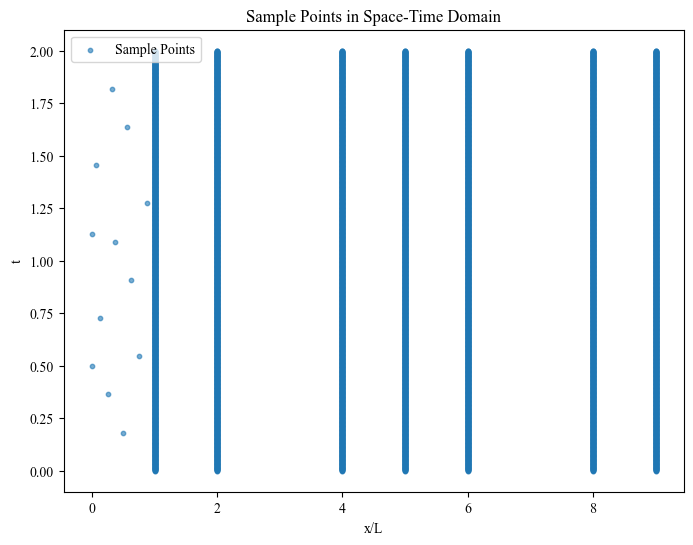

Compiling model...
Building feed-forward neural network...
output shape before return: (None, 1)
'build' took 0.092135 s



C:\Users\PS\anaconda3\envs\deepxde\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\PS\AppData\Local\Temp\ipykernel_33212\2146978090.py:71: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w = tf.layers.dense(t, w_nodenum, activation_func)
C:\Users\PS\AppData\Local\Temp\ipykernel_33212\2146978090.py:73: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w = tf.layers.dense(w, w_nodenum, activation_func)
C:\Users\PS\AppData\Local\Temp\ipykernel_33212\2146978090.py:74: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w = 0.0001*tf.layers.dense(w, 7, None)
C:\Users\PS\App

'compile' took 0.321965 s

Training model...

Step      Train loss              Test loss               Test metric
0         [0.00e+00, 2.73e+03]    [0.00e+00, 2.73e+03]    []  
1000      [0.00e+00, 1.91e+02]    [0.00e+00, 1.91e+02]    []  
2000      [0.00e+00, 1.66e+02]    [0.00e+00, 1.66e+02]    []  
3000      [0.00e+00, 1.11e+02]    [0.00e+00, 1.11e+02]    []  
4000      [0.00e+00, 8.28e+01]    [0.00e+00, 8.28e+01]    []  
5000      [0.00e+00, 1.65e+02]    [0.00e+00, 1.65e+02]    []  
6000      [0.00e+00, 1.25e+02]    [0.00e+00, 1.25e+02]    []  
7000      [0.00e+00, 8.74e+01]    [0.00e+00, 8.74e+01]    []  
8000      [0.00e+00, 6.27e+01]    [0.00e+00, 6.27e+01]    []  
9000      [0.00e+00, 8.23e+01]    [0.00e+00, 8.23e+01]    []  
10000     [0.00e+00, 7.11e+01]    [0.00e+00, 7.11e+01]    []  
11000     [0.00e+00, 8.93e+01]    [0.00e+00, 8.93e+01]    []  
12000     [0.00e+00, 6.44e+01]    [0.00e+00, 6.44e+01]    []  
13000     [0.00e+00, 3.17e+01]    [0.00e+00, 3.17e+01]    []  
14

In [3]:

#————————————————————————————————————————————#
def generate_labeled_data():
    data_w = np.loadtxt("displacement.txt")
    x_data = data_w[:, 0].reshape(-1, 1)  
    y_data = data_w[:, 1:].T 
    t_data = np.arange(0, 2.001, 0.001).reshape(-1, 1)
    valid_indices = (t_data >= 0) & (t_data <= 2)
    t_data_filtered = t_data[valid_indices]
    y_data_filtered = y_data[valid_indices.flatten(), :]
    space_values = [1, 2, 4, 5, 6, 8, 9]
    space_indices = []
    for value in space_values:
        idx = (np.abs(x_data.flatten() - value)).argmin()  
        space_indices.append(idx)
    space_indices = np.array(space_indices)
    x_data_filtered = x_data[space_indices]  
    y_data_filtered_space = y_data_filtered[:, space_indices] 
    X, T = np.meshgrid(x_data_filtered.flatten(), t_data_filtered.flatten())

    inputs = np.hstack([X.flatten()[:, None], T.flatten()[:, None]])
    outputs = y_data_filtered_space.flatten()[:, None]
    print("输入特征形状:", inputs.shape)  
    print("输出标签形状:", outputs.shape) 
   
    sample_ratio = 1
    num_samples = int(sample_ratio * inputs.shape[0])
    indices = np.random.choice(inputs.shape[0], num_samples, replace=False)
    # 根据随机选择的索引保留对应的样本
    sampled_inputs = inputs[indices]
    sampled_outputs = outputs[indices]
    print(f"二次随机采样后的样本数量: {num_samples}")
    return sampled_inputs, sampled_outputs

#————————————————————— 损失函数定义 ———————————————————————#
xt_data, y_data = generate_labeled_data()
observe_y1 = dde.icbc.PointSetBC(xt_data, y_data, component=0)  

geom = dde.geometry.Interval(0, 1) 
timedomain = dde.geometry.TimeDomain(0, 2) 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def beam(X, Y):  
    a=0.0*Y
    return a

data = dde.data.TimePDE(geomtime,
                        beam, 
                        [observe_y1],  # 使用 PointSetBC
                        num_domain=10,
                        num_boundary=10)#anchors=xt_data
train_points = data.train_x

# 绘制采样点
plt.figure(figsize=(8, 6))
plt.scatter(train_points[:, 0], train_points[:, 1], s=10, alpha=0.6, label="Sample Points")
plt.xlabel("x/L")
plt.ylabel("t")
plt.title("Sample Points in Space-Time Domain")
plt.legend()
plt.show()

#————————————————————— ——————————————————————#
net = dde.maps.FNN([2] + [8], None, "Glorot uniform")    #基础架构
w_nodenum = 128
w_layer = 4
activation_func = "relu"
def modify_output(X, Y):   #修正架构
    x = X[:,0:1]
    t = X[:,1:2]
    y1 = tf.zeros_like(x)  # 创建与 x 形状相同的零张量
    w = tf.layers.dense(t, w_nodenum, activation_func)
    for i in range(w_layer):
        w = tf.layers.dense(w, w_nodenum, activation_func)
    w = 0.0001*tf.layers.dense(w, 7, None)
    
    FAI= pre_model(x)
    for i in range(1, 8):
        wi_term = w[:, (i - 1):i]
        FAIi_term=FAI[:, (i - 1):i]
        y1 += wi_term * FAIi_term  # 逐项累加 
    print(f"output shape before return: {y1.shape}")
    
    r= tf.layers.dense(X, w_nodenum, activation_func)
    for i in range(w_layer):
        r = tf.layers.dense(r, 64, activation_func)
    r = 0.0001*tf.layers.dense(w, 1, None)*X[:, 0:1]*(X[:, 0:1]-10)
    y2 = y1 + r
    return tf.concat([y1, w], axis=1)     


net.apply_output_transform(modify_output)
model = dde.Model(data, net)

epochs=10000
#variable = dde.callbacks.VariableValue(D, period=1000, filename="variables.dat")

model.compile("adam",
              lr=1e-3,loss=["MAE","MAE"],loss_weights=[0,1e7])
loss_history, train_state = model.train(iterations=4*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)
model.compile("adam",
              lr=1e-4,loss=["MAE","MAE"],loss_weights=[0,1e7])
loss_history, train_state = model.train(iterations=4*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)
model.compile("adam",
              lr=1e-5,loss=["MAE","MAE"],loss_weights=[0,1e7])
loss_history, train_state = model.train(iterations=4*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)



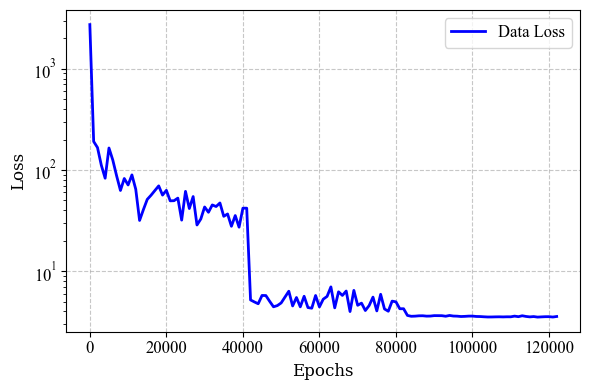

In [4]:
# 假设 train_loss 包含每个 epoch 的 7 个损失值
train_loss = loss_history.loss_train

# 提取每个 epoch 的第一个损失值（假设是物理损失）和第二个损失值（假设是数据损失）
Physics_losses = [loss[0] for loss in train_loss]
Data_losses = [loss[1] for loss in train_loss]

total_losses = [p + d for p, d in zip(Physics_losses, Data_losses)]

epochs = np.arange(len(train_loss)) * 1000  # 假设每个点是 1000 个 epoch

font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}
    # 绘制损失函数
plt.figure(figsize=(6, 4))
# 使用不同的线型和颜色
plt.plot(epochs, Data_losses, label='Data Loss', color='blue', linestyle='-', linewidth=2)  # 点线
#plt.plot(epochs, physics_losses, label='Physics Loss', color='blue', linestyle='-.')  # 点划线
#plt.plot(epochs, total_losses, label='Total Loss', color='red', linestyle='-')  # 点线
plt.yscale('log')  # 将 Y 轴设置为对数坐标
plt.title('', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Loss', fontdict=font)

plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  # 更加淡化的网格
plt.savefig("损失函数.png", dpi=300)
plt.show()

输入特征形状: (2003001, 2)
输出标签形状: (2003001, 1)


C:\Users\PS\AppData\Local\Temp\ipykernel_33212\1038729383.py:49: RuntimeWarning: invalid value encountered in divide
  R_y_error = abs((y_pre_reshaped - y_true_reshaped)/y_true_reshaped)


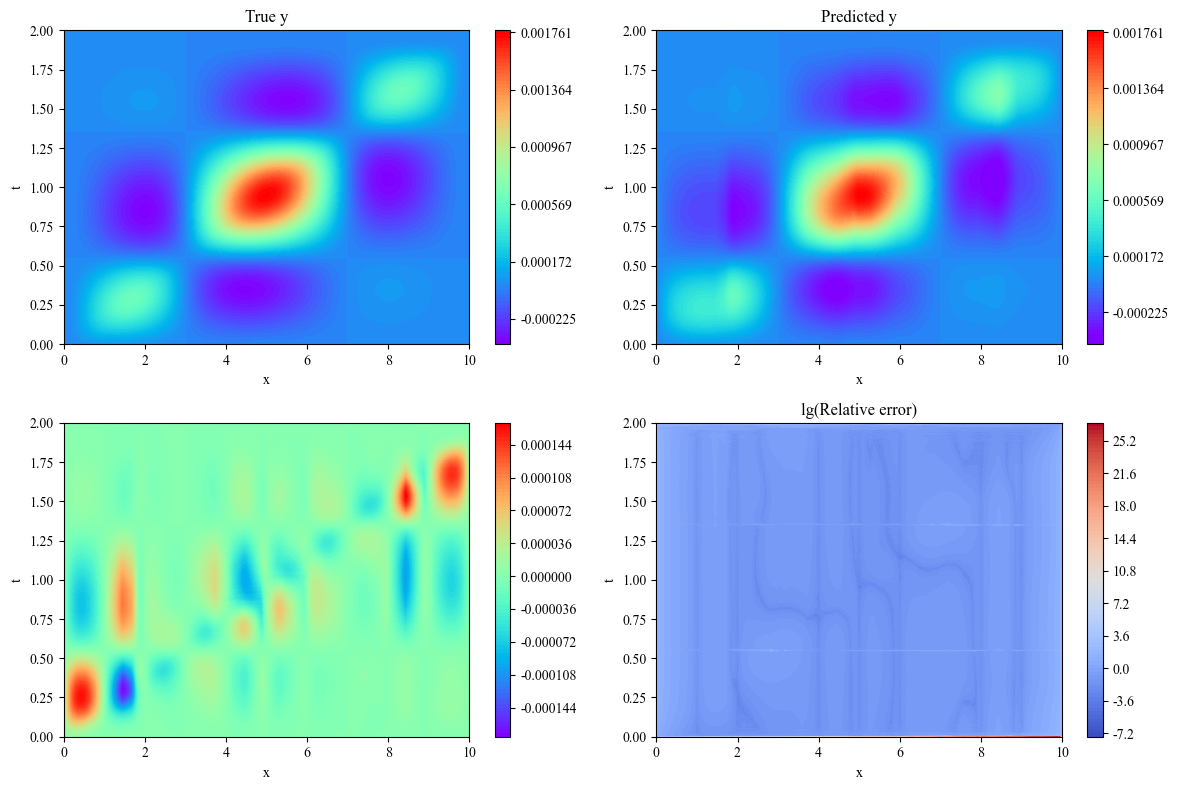

In [5]:
from matplotlib.colors import Normalize

def generate_labeled_data2():
    data_w = np.loadtxt("displacement.txt")
    x_data = data_w[:, 0].reshape(-1, 1)  # 第一列为输入特征，调整形状为二维
    y_data = data_w[:, 1:].T  # 假设 y_data 从第三列到2003列
    t_data = np.arange(0, 2.001, 0.001).reshape(-1, 1)# 生成 t 数据，3001x1101*1

    # 根据指定的时间范围 (0 <= t <= 25) 过滤 `t_data` 和 `y_data`
    valid_indices = (t_data >= 0) & (t_data <= 2)
    t_data_filtered = t_data[valid_indices]
    y_data_filtered = y_data[valid_indices.flatten(), :]  # 保留所有空间位置的过滤时间步

    X, T = np.meshgrid(x_data, t_data_filtered.flatten())

    inputs = np.hstack([X.flatten()[:, None], T.flatten()[:, None]])
    # 输出数据（标签）
    outputs = y_data_filtered.flatten()[:, None]

    # 输出输入和输出的形状
    print("输入特征形状:", inputs.shape)  # 应为 (N, 2)，N 为总样本数
    print("输出标签形状:", outputs.shape)  # 应为 (N, 1)，N 为总样本数
    return inputs, outputs

xt2_data, y2_data = generate_labeled_data2()


predictions = model.predict(xt2_data)
Y_PRE=predictions [:,0:1]
w1=predictions [:,1:2]
w2=predictions [:,2:3]
w3=predictions [:,3:4]
w4=predictions [:,4:5]
w5=predictions [:,5:6]
w6=predictions [:,6:7]
w7=predictions [:,7:8]

X = xt2_data[:, 0].reshape(-1, 1001)  # 假设 x 数据有 101 个样本
T = xt2_data[:, 1].reshape(-1, 1001)  # 对应的 t 数据

y_true_reshaped= y2_data.reshape(-1, 1001)
y_pre_reshaped = Y_PRE.reshape(-1, 1001)


# 计算误差
y_error = y_pre_reshaped - y_true_reshaped


R_y_error = abs((y_pre_reshaped - y_true_reshaped)/y_true_reshaped)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10  # 设定字体大小为14

# Get the minimum and maximum values to set the same range for both colorbars


vmin = np.min(y_true_reshaped)
vmax = np.max(y_pre_reshaped)
norm = Normalize(vmin=vmin, vmax=vmax)
# 创建子图
plt.figure(figsize=(12, 8))

# 绘制预测结果的热图
# Plot True y
plt.subplot(2, 2, 1)
cp1 = plt.contourf(X, T, y_true_reshaped, levels=100, cmap='rainbow', norm=norm)
cbar1 = plt.colorbar(cp1, label='')  # Add colorbar
cbar1.set_ticks(np.linspace(-0.000225, vmax, 6))  # Adjust number of ticks
plt.xlabel('x')
plt.ylabel('t')
plt.title('True y')

# Plot Predicted y
plt.subplot(2, 2, 2)
cp2 = plt.contourf(X, T, y_pre_reshaped, levels=100, cmap='rainbow', norm=norm)
cbar2 = plt.colorbar(cp2, label='')  # Add colorbar
cbar2.set_ticks(np.linspace(-0.000225, vmax, 6))  # Adjust number of ticks
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted y')


# 绘制误差分布的热图
plt.subplot(2, 2, 3)
plt.contourf(X, T, y_error, levels=100, cmap='rainbow')
plt.colorbar(label='')
plt.xlabel('x')
plt.ylabel('t')
plt.title('')

log_R_y_error = np.log10(R_y_error) 
plt.subplot(2, 2, 4)
plt.contourf(X, T, log_R_y_error, levels=100, cmap='coolwarm')
plt.colorbar(label='')
plt.xlabel('x')
plt.ylabel('t')
plt.title('lg(Relative error)')
plt.tight_layout()
plt.savefig("数据驱动 响应预测.png", dpi=300)
plt.show()


Pearson correlation coefficient: 0.9960818941485816
决定系数 (R²): 0.9921791398506261


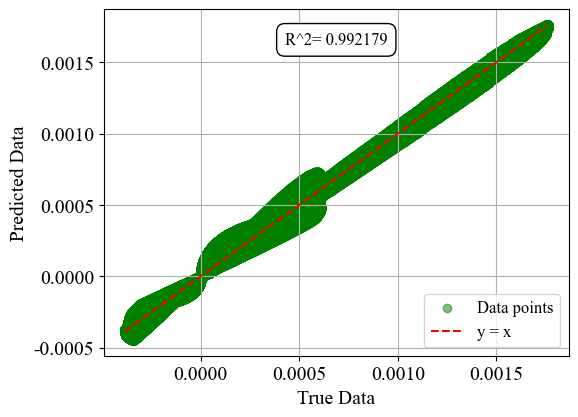

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 设置字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  # 设定字体大小为14

# 创建图形
plt.figure(figsize=(6, 4.5))

# 绘制真实值和预测值的散点图
plt.scatter(y2_data, Y_PRE, color="green", alpha=0.5, label="Data points")
y2_data = y2_data.flatten()
Y_PRE = Y_PRE.flatten()
# 计算皮尔逊相关系数
correlation, _ = pearsonr(y2_data, Y_PRE)
print(f"Pearson correlation coefficient: {correlation}")
r_squared = correlation ** 2
print(f"决定系数 (R²): {r_squared}")
# 在图中添加相关系数
plt.text(0.5, 0.9, f"R^2= {r_squared:.6f}", fontsize=12, ha='center', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# 绘制y = x线（完美预测的参考线）
plt.plot([min(y2_data), max(y2_data)], [min(y2_data), max(y2_data)], color="red", linestyle="--", label="y = x")

# 添加标签和图例
plt.xlabel("True Data")
plt.ylabel("Predicted Data")
plt.title("")
plt.xticks(fontsize=14)  # 设置x轴刻度字体大小
plt.yticks(fontsize=14)  # 设置y轴刻度字体大小
plt.legend(loc='lower right', fontsize=12)  #
plt.grid()

# 保存图像
plt.savefig("预测精度.png", dpi=300)

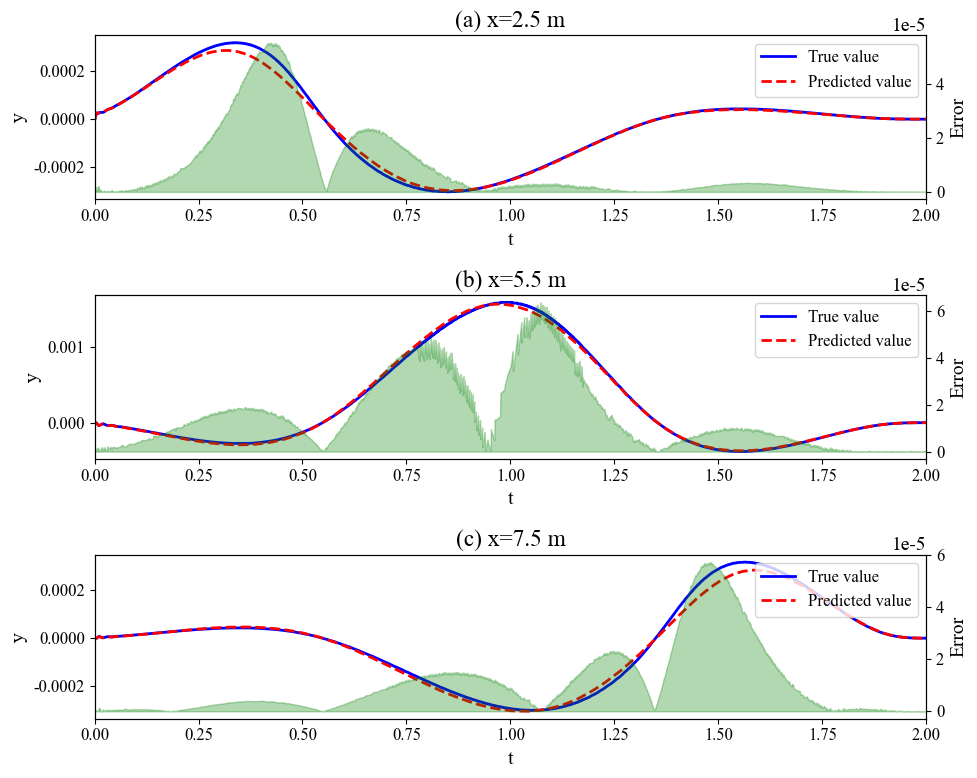

In [7]:


# 获取这些位置的时程响应（预测值和真实值）
t_data = xt2_data[:, 1].reshape(-1, 1001)  # 时间数据 (3001, 101)

y_true_reshaped= y2_data.reshape(-1, 1001)

y_pre_reshaped = Y_PRE.reshape(-1, 1001)
# 真实值
y_true_1_4 = y_true_reshaped[:, 250:251]
y_true_1_2 = y_true_reshaped[:, 550:551]
y_true_3_4 = y_true_reshaped[:, 750:751]

# 预测值
y_pred_1_4 = y_pre_reshaped[:, 250:251]
y_pred_1_2 = y_pre_reshaped[:, 550:551]
y_pred_3_4 = y_pre_reshaped[:, 750:751]

relative_error_1_4 = np.abs(y_true_1_4 - y_pred_1_4) / np.abs(y_true_1_4)
relative_error_1_2 = np.abs(y_true_1_2 - y_pred_1_2) / np.abs(y_true_1_2)
relative_error_3_4 = np.abs(y_true_3_4 - y_pred_3_4) / np.abs(y_true_3_4)
Error_1_4 = np.abs(y_true_1_4 - y_pred_1_4) 
Error_1_2 = np.abs(y_true_1_2 - y_pred_1_2)
Error_3_4 = np.abs(y_true_3_4 - y_pred_3_4)


# 绘制对比图并添加对数相对误差，使用右侧坐标轴
plt.figure(figsize=(10, 8))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  # 设定字体大小为14

# 添加一个小常数来避免对数中出现负值或零
epsilon = 1e-10

# 绘制1/4位置的对比
plt.subplot(3, 1, 1)
ax1 = plt.gca()  # 获取当前坐标轴
ax2 = ax1.twinx()  # 创建一个共享x轴的右侧坐标轴

ax1.plot(t_data[:, 0], y_true_1_4, label='True value', color='blue', linestyle='-', linewidth=2)
ax1.plot(t_data[:, 0], y_pred_1_4, label='Predicted value', color='red', linestyle='--', linewidth=2)

# 计算对数相对误差并进行填充
#ax2.plot(t_data[:, 0], Error_1_4.flatten(), label='', color='gray', linestyle='-.', linewidth=1)

# 填充对数相对误差区域
ax2.fill_between(t_data[:, 0], 0, Error_1_4.flatten(), color='green', alpha=0.3)

ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.set_ylabel('Error')
ax1.set_xlim(0, 2)

# 设置刻度字体大小
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax1.set_title('(a) x=2.5 m')
ax1.legend(loc='upper right', fontsize=12)

# 绘制1/2位置的对比
plt.subplot(3, 1, 2)
ax1 = plt.gca()  # 获取当前坐标轴
ax2 = ax1.twinx()  # 创建一个共享x轴的右侧坐标轴



ax1.plot(t_data[:, 0], y_true_1_2, label='True value', color='blue', linestyle='-', linewidth=2)
ax1.plot(t_data[:, 0], y_pred_1_2, label='Predicted value', color='red', linestyle='--', linewidth=2)

# 计算对数相对误差并进行填充
log_relative_error_1_2 = np.log(np.abs(relative_error_1_2.flatten()) + epsilon)
#ax2.plot(t_data[:, 0], Error_1_2.flatten(), label='', color='gray', linestyle='-', linewidth=1)

# 填充对数相对误差区域
ax2.fill_between(t_data[:, 0], 0, Error_1_2.flatten(), color='green', alpha=0.3)

ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.set_ylabel('Error')
ax1.set_xlim(0, 2)

# 设置刻度字体大小
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax1.set_title('(b) x=5.5 m')
ax1.legend(loc='upper right', fontsize=12)

# 绘制3/4位置的对比
plt.subplot(3, 1, 3)
ax1 = plt.gca()  # 获取当前坐标轴
ax2 = ax1.twinx()  # 创建一个共享x轴的右侧坐标轴

ax1.plot(t_data[:, 0], y_true_3_4, label='True value', color='blue', linestyle='-', linewidth=2)
ax1.plot(t_data[:, 0], y_pred_3_4, label='Predicted value', color='red', linestyle='--', linewidth=2)

# 计算对数相对误差并进行填充
log_relative_error_3_4 = np.log(np.abs(relative_error_3_4.flatten()) + epsilon)
#ax2.plot(t_data[:, 0], Error_3_4.flatten(), label='', color='gray', linestyle='-', linewidth=1)

# 填充对数相对误差区域
ax2.fill_between(t_data[:, 0], 0, Error_3_4.flatten(), color='green', alpha=0.3)

ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.set_ylabel('Error')
ax1.set_xlim(0, 2)

# 设置刻度字体大小
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax1.set_title('(c) x=7.5 m')
ax1.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig("响应对比.png", dpi=300)
plt.show()
